In [19]:
#!pip install arch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as sp
import warnings
import random

# Definir semente para reprodutibilidade
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
# Baixando os dados históricos do Bitcoin
import yfinance as yf

# Obtendo a série histórica do Bitcoin (BTC-USD)
btc_data = yf.download("BTC-USD", start="2014-01-01", end="2024-11-20")

# Calculando o retorno diário
btc_data['Daily_Return'] = np.log(btc_data['Adj Close']/btc_data['Adj Close'].shift(1))

# Removendo valores nulos
btc_data = btc_data.dropna()

# Rescaling dados para melhorar estimação
btc_data['Daily_Return'] = btc_data['Daily_Return']*10

[*********************100%%**********************]  1 of 1 completed


c:\Users\lhaon\anaconda3\Lib\site-packages\yfinance\utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\lhaon\AppData\Local\Temp\ipykernel_8484\2949846883.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data['Daily_Return'] = btc_data['Daily_Return']*10


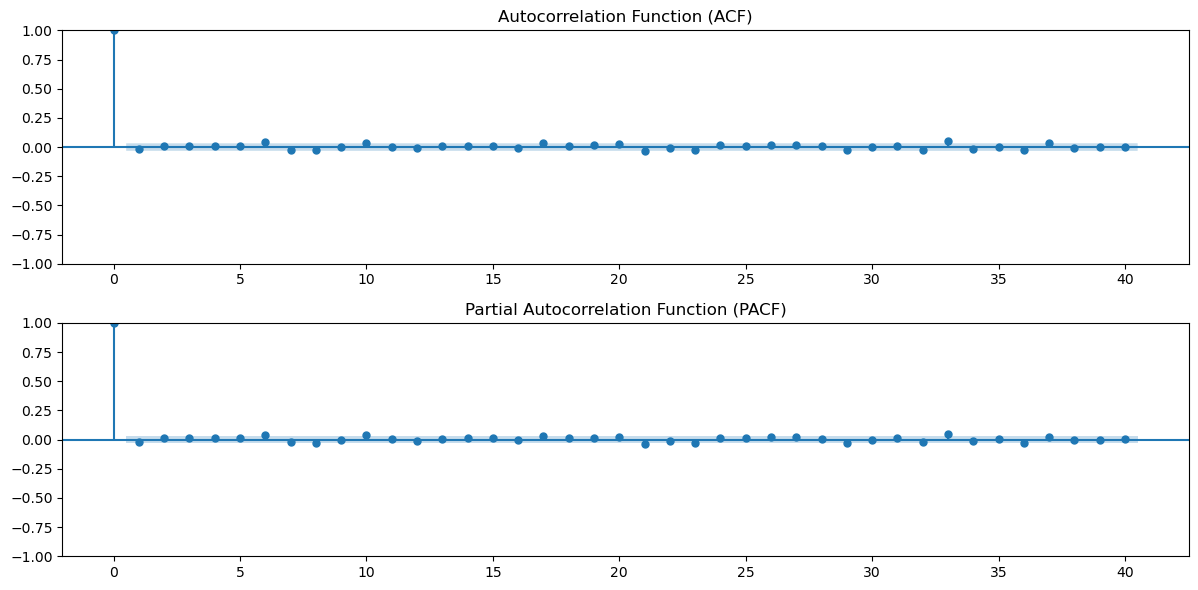

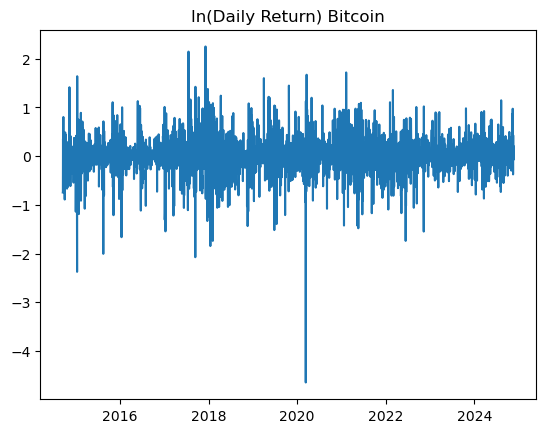

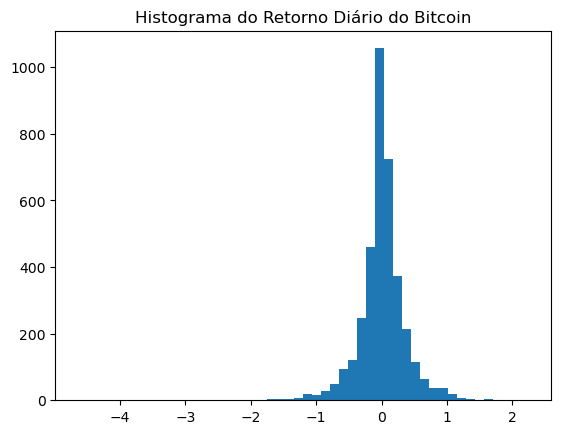

(count    3716.000000
 mean        0.014284
 std         0.365738
 min        -4.647302
 25%        -0.126627
 50%         0.013562
 75%         0.168666
 max         2.251190
 Name: Daily_Return, dtype: float64,
 (-18.51814431816383,
  2.1103729378464396e-30,
  9,
  3706,
  {'1%': -3.432115740743458,
   '5%': -2.862320206526435,
   '10%': -2.567185315153822},
  3041.10893878349))

In [21]:
# Estatísticas descritivas do retorno diário
desc_stats = btc_data['Daily_Return'].describe()

# Teste de estacionaridade (ADF Test)
adf_test = adfuller(btc_data['Daily_Return'])

# Plotando ACF e PACF
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(btc_data['Daily_Return'], lags=40, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

plt.subplot(2, 1, 2)
plot_pacf(btc_data['Daily_Return'], lags=40, ax=plt.gca())
plt.title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

plt.plot(btc_data['Daily_Return'])
plt.title('ln(Daily Return) Bitcoin')
plt.show()

plt.hist(btc_data['Daily_Return'], bins = 50)
plt.title("Histograma do Retorno Diário do Bitcoin")
plt.show()

desc_stats, adf_test


In [22]:
#testes de normalidade
ks_stat, ks_p = sp.kstest(btc_data['Daily_Return'], 'norm')

print("Kolmogorov-Smirnov Test: Statistic =", ks_stat, ", p-value =", ks_p)
print(f"Normal test results: Statistic = {sp.normaltest(btc_data['Daily_Return'])} & P-value = {sp.normaltest(btc_data['Daily_Return'])}")
print(f"Shapiro results: Statistic = {sp.shapiro(btc_data['Daily_Return'])}")

#testando por heterocedasticidade
white_test1 = het_arch(btc_data['Daily_Return'], nlags = 8)

#print results of White's test
print(f"P valor do teste de heterecedasticidade: {white_test1[3]}")


Kolmogorov-Smirnov Test: Statistic = 0.26223431594717445 , p-value = 5.7224750728999466e-226
Normal test results: Statistic = NormaltestResult(statistic=970.3776327219372, pvalue=1.928298987703736e-211) & P-value = NormaltestResult(statistic=970.3776327219372, pvalue=1.928298987703736e-211)
Shapiro results: Statistic = ShapiroResult(statistic=0.904721397841259, pvalue=2.766888115234857e-43)
P valor do teste de heterecedasticidade: 1.3644673859709791e-22


C:\Users\lhaon\AppData\Local\Temp\ipykernel_8484\1216427290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data["DR2"] = (btc_data["Daily_Return"] - np.mean(btc_data["Daily_Return"]))**2


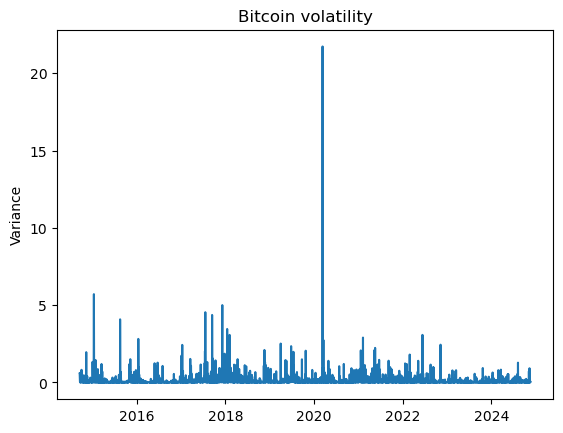

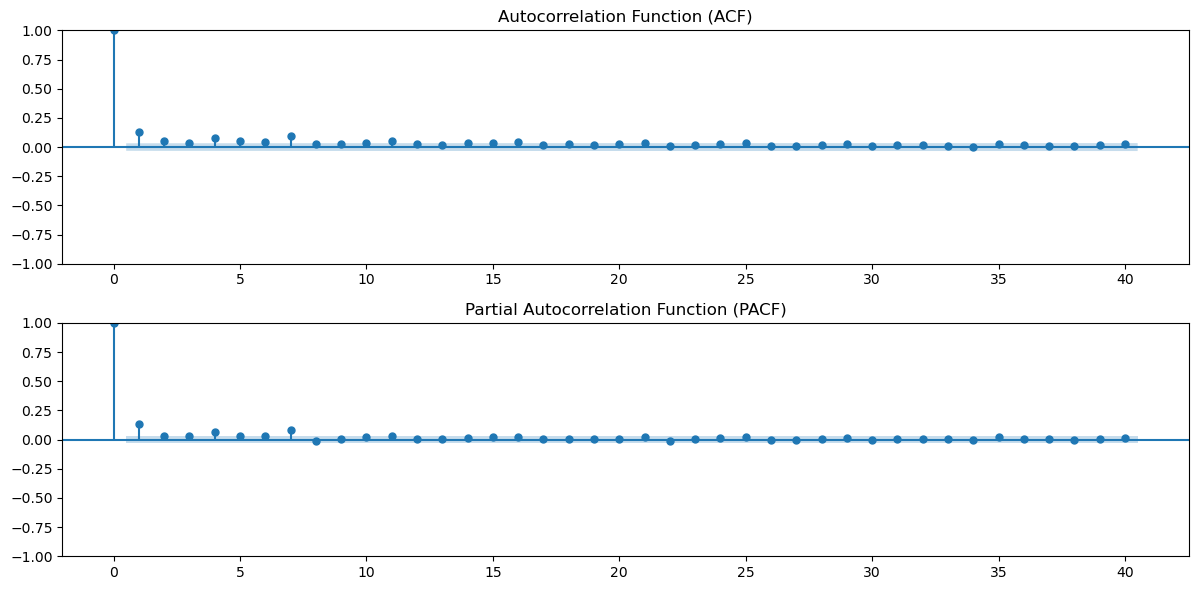

In [23]:
btc_data["DR2"] = (btc_data["Daily_Return"] - np.mean(btc_data["Daily_Return"]))**2
plt.plot(btc_data["DR2"])
plt.title('Bitcoin volatility')
plt.ylabel('Variance')
plt.show()

# Plotando ACF e PACF
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(btc_data['DR2'], lags=40, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

plt.subplot(2, 1, 2)
plot_pacf(btc_data['DR2'], lags=40, ax=plt.gca())
plt.title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

# Garch

In [24]:
# Determine the split index
test_size = int(len(btc_data) * 0.2)
train_size = len(btc_data) - test_size
split_index = train_size

# Split into train and test
train_data = btc_data['Daily_Return'].iloc[:split_index]
test_data = btc_data['Daily_Return'].iloc[split_index:]

print("Train Set:")
print(train_data)
print("\nTest Set:")
print(test_data)

Train Set:
Date
2014-09-18   -0.746434
2014-09-19   -0.724015
2014-09-20    0.351112
2014-09-21   -0.249677
2014-09-22    0.083174
                ...   
2022-11-03    0.025011
2022-11-04    0.453320
2022-11-05    0.063852
2022-11-06   -0.168785
2022-11-07   -0.155879
Name: Daily_Return, Length: 2973, dtype: float64

Test Set:
Date
2022-11-08   -1.054286
2022-11-09   -1.548895
2022-11-10    1.020374
2022-11-11   -0.319185
2022-11-12   -0.138981
                ...   
2024-11-15    0.428021
2024-11-16   -0.055888
2024-11-17   -0.079004
2024-11-18    0.077255
2024-11-19    0.196975
Name: Daily_Return, Length: 743, dtype: float64


(1, 1)
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           Daily_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1172.42
Distribution:                  Normal   AIC:                           2352.83
Method:            Maximum Likelihood   BIC:                           2376.82
                                        No. Observations:                 2973
Date:                Sun, Nov 24 2024   Df Residuals:                     2972
Time:                        13:27:34   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0173  6.383e-03      2.704  6.857e

C:\Users\lhaon\AppData\Local\Temp\ipykernel_8484\588589043.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data['GARCH_Error'] = best_model.std_resid


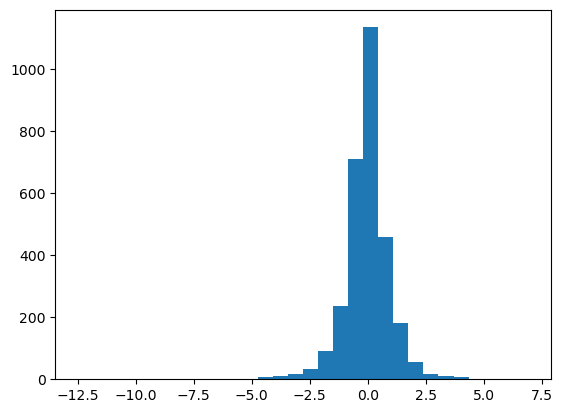

In [25]:
model = arch_model(train_data, vol='Garch', p=1, q=1)
best_model = model.fit(disp="off")

best_order = (1, 1)

for i in range(1,6):
    for j in range(1,6):
        model = arch_model(btc_data['Daily_Return'], vol='Garch', p=i, q=j)
        results = model.fit(disp="off")
        if results.aic < best_model.aic:
            best_order = (i, j)
            best_model = results

print(best_order)

# Calculando erros padrões
btc_data['GARCH_Error'] = best_model.std_resid

plt.hist(btc_data['GARCH_Error'], bins = 30)

print(best_model.summary())

#testando por heterocedasticidade
white_test = het_arch(best_model.std_resid, nlags = 8)

#print results of White's test
print(f"P valor do teste de heterocedasticidade: {white_test[3]}")


In [26]:
#testes de normalidade
ks_stat, ks_p = sp.kstest(btc_data['GARCH_Error'][:split_index], 'norm')

print("Kolmogorov-Smirnov Test: Statistic =", ks_stat, ", p-value =", ks_p)
print(f"Normal test results: Statistic = {sp.normaltest(btc_data['GARCH_Error'][:split_index])} & P-value = {sp.normaltest(btc_data['GARCH_Error'][:split_index])}")
print(f"Shapiro results: Statistic = {sp.shapiro(btc_data['GARCH_Error'][:split_index])}")

Kolmogorov-Smirnov Test: Statistic = 0.08489348667168367 , p-value = 4.338855015838006e-19
Normal test results: Statistic = NormaltestResult(statistic=913.1422843712194, pvalue=5.172164778902622e-199) & P-value = NormaltestResult(statistic=913.1422843712194, pvalue=5.172164778902622e-199)
Shapiro results: Statistic = ShapiroResult(statistic=0.9060221080400279, pvalue=1.9438888516582527e-39)


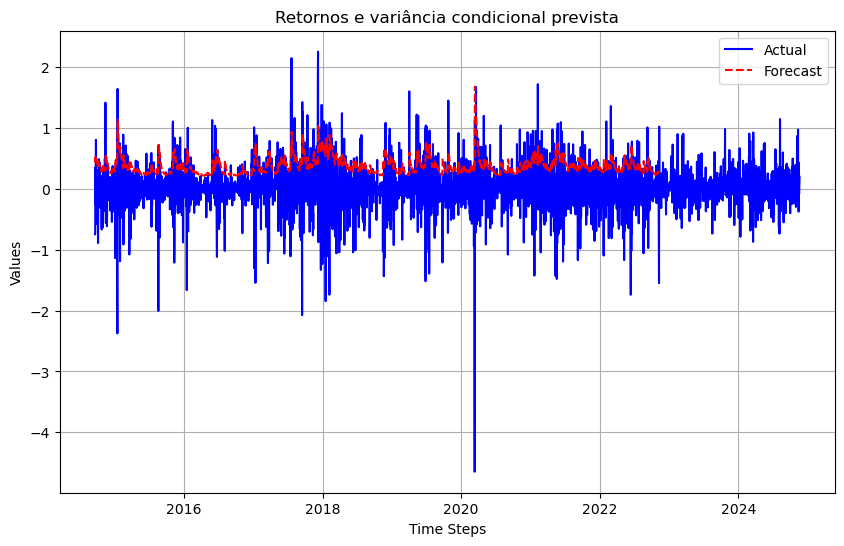

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(btc_data['Daily_Return'], label='Actual', color='blue')
plt.plot(best_model.conditional_volatility, label='Forecast', color='red', linestyle='--')
plt.legend()
plt.title('Retornos e variância condicional prevista')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [28]:
history = train_data.tolist()
forecasts = []

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Perform one-step-ahead forecasting for each point in the test set
for t in range(len(test_data)):
    # Fit the model on history and forecast the next step
    model = arch_model(history, vol='Garch', p=1, q=1)
    model_fit = model.fit(disp="off")
    forecast = model_fit.forecast(horizon=1)

    # Get the forecasted mean and conditional variance
    forecast_variance = forecast.variance['h.1'].iloc[-1]

    # Append forecasted mean to forecasts and calculate the error
    forecasts.append(forecast_variance)
    actual = test_data.iloc[t]

    # Update history with the actual value from the test set
    history.append(actual)

# Create a DataFrame to store forecasts and errors
forecast_df = pd.DataFrame({
    'Forecast': forecasts,
    'Actual': test_data,
})

# Display the forecast DataFrame
print(forecast_df.head())

            Forecast    Actual
Date                          
2022-11-08  0.074405 -1.054286
2022-11-09  0.212784 -1.548895
2022-11-10  0.507982  1.020374
2022-11-11  0.563747 -0.319185
2022-11-12  0.490870 -0.138981


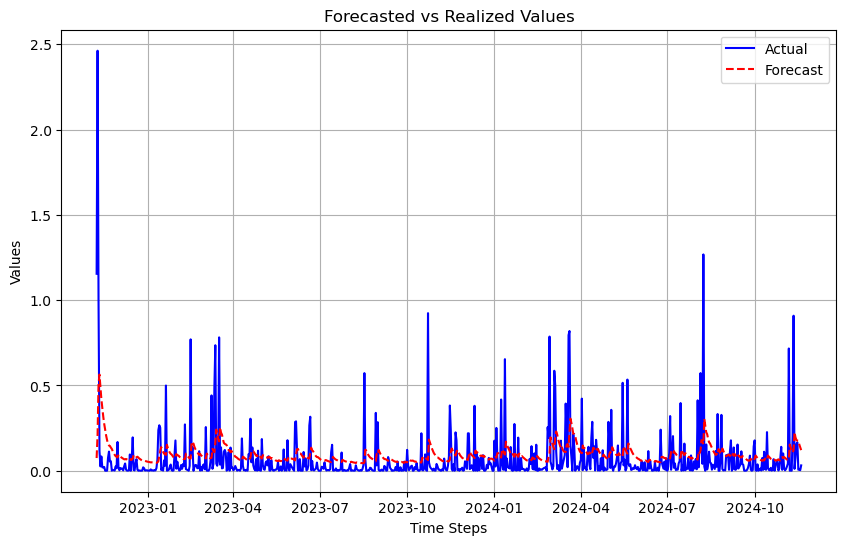

In [29]:
plt.figure(figsize=(10, 6))
plt.plot((forecast_df['Actual'] - np.mean(forecast_df['Actual']))**2, label='Actual', color='blue')
plt.plot(forecast_df['Forecast'], label='Forecast', color='red', linestyle='--')
plt.legend()
plt.title('Forecasted vs Realized Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [30]:
varReal = (forecast_df['Actual'] - np.mean(forecast_df['Actual']))**2
mseG = mean_squared_error(varReal, forecast_df['Forecast'])
print(f"Erro quadratico médio: {mseG}")

Erro quadratico médio: 0.02814432265331944


# LSTM

In [31]:
# LTSM 1
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Function to create sequences
def create_sequences(series, lookback):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i + lookback].values)
        y.append(series[i + lookback])
    return np.array(X), np.array(y)

# Set the lookback period (number of previous steps to consider)
lookback = 64

# Create sequences
X, y = create_sequences(btc_data['DR2'], lookback)

print(f"Input shape: {X.shape}, Target shape: {y.shape}")

# Reshape for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Add 1 feature dimension
print(f"Reshaped Input: {X.shape}")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(lookback, 1)),
    Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mse')

print(model.summary())

# Split into train and test sets
train_size = len(X) - test_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

# Predict on test set
y_predLSTM = model.predict(X_test)

# Evaluate performance
mseLSTM = mean_squared_error(y_test, y_predLSTM)
print(f"Mean Squared Error: {mseLSTM}")

Input shape: (3652, 64), Target shape: (3652,)
Reshaped Input: (3652, 64, 1)


C:\Users\lhaon\AppData\Local\Temp\ipykernel_8484\1294062881.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(series[i + lookback])
c:\Users\lhaon\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.4601 - val_loss: 0.0284
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4510 - val_loss: 0.0285
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4501 - val_loss: 0.0281
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4495 - val_loss: 0.0280
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4490 - val_loss: 0.0278
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4487 - val_loss: 0.0277
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4484 - val_loss: 0.0277
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4482 - val_loss: 0.0276
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.4480 - val_loss: 0.0276
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4478 - val_loss: 0.0276
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4476 - val_loss: 0.0276
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms

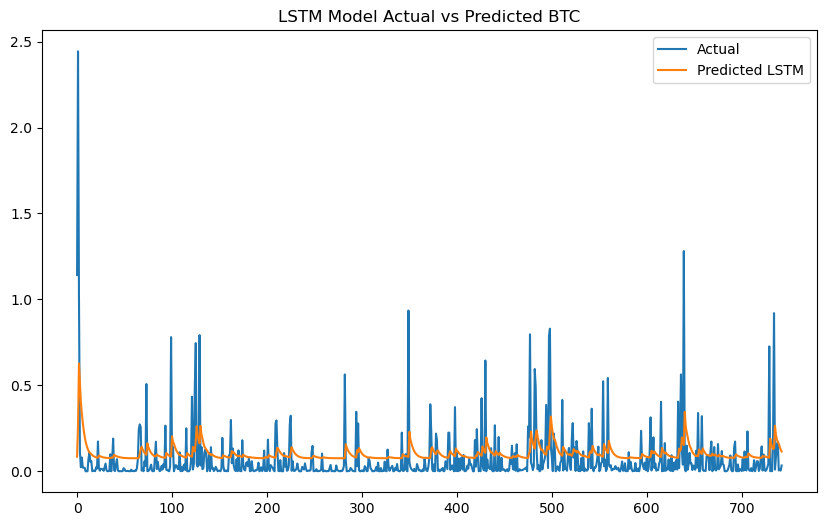

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="Actual")
plt.plot(range(len(y_predLSTM)), y_predLSTM, label="Predicted LSTM")
plt.legend()
plt.title("LSTM Model Actual vs Predicted BTC")
plt.show()

Input shape: (3652, 64), Target shape: (3652,)
Reshaped Input: (3652, 64, 1)


C:\Users\lhaon\AppData\Local\Temp\ipykernel_8484\2002645286.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(series[i + lookback])
c:\Users\lhaon\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.4597 - val_loss: 0.0293
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.4524 - val_loss: 0.0285
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.4520 - val_loss: 0.0288
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.4515 - val_loss: 0.0287
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.4497 - val_loss: 0.0290
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.4478 - val_loss: 0.0289
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.4486 - val_loss: 0.0289
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.4502 - val_loss: 0.0284
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.4498 - val_loss: 0.0292
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.4494 - val_loss: 0.0289
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.4477 - val_loss: 0.0285
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms

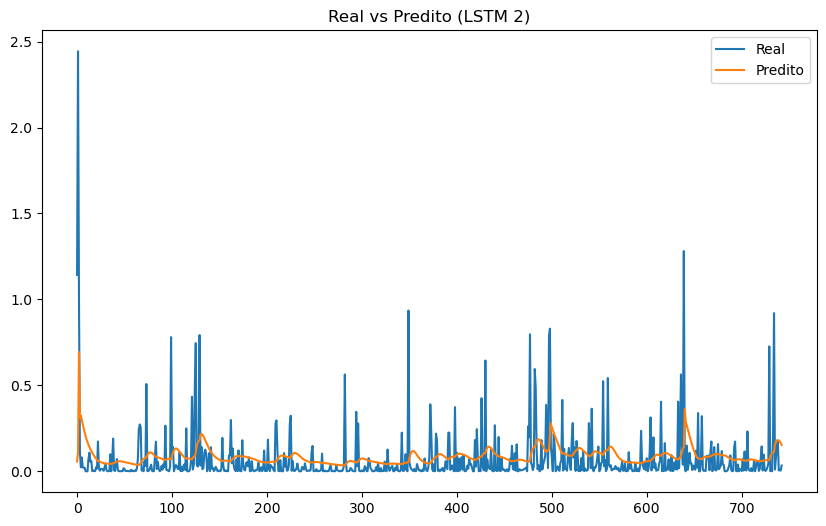

In [33]:
#LSTM 2

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Função para criar sequências
def create_sequences(series, lookback):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i + lookback].values)
        y.append(series[i + lookback])
    return np.array(X), np.array(y)

# Período de lookback
lookback = 64

# Criando sequências
X, y = create_sequences(btc_data['DR2'], lookback)

print(f"Input shape: {X.shape}, Target shape: {y.shape}")

# Redimensionando para LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Adicionando dimensão de features
print(f"Reshaped Input: {X.shape}")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Criando o modelo LSTM 2 com mais camadas e Dropout para evitar overfitting
model_lstm_2 = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(lookback, 1)),  # LSTM 1
    Dropout(0.2),  # Dropout para reduzir overfitting
    LSTM(50, activation='relu'),  # LSTM 2
    Dropout(0.2),  # Dropout após a segunda camada LSTM
    Dense(1)  # Camada de saída
])

model_lstm_2.compile(optimizer='adam', loss='mse')

print(model_lstm_2.summary())

# Dividir os dados em treino e teste
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Treinar o modelo
history = model_lstm_2.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

# Prever no conjunto de teste
y_pred_lstm_2 = model_lstm_2.predict(X_test)

# Avaliar o desempenho
mse_lstm_2 = mean_squared_error(y_test, y_pred_lstm_2)
print(f"Mean Squared Error: {mse_lstm_2}")

# Gráfico de comparação
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="Real")
plt.plot(range(len(y_pred_lstm_2)), y_pred_lstm_2, label="Predito")
plt.legend()
plt.title("Real vs Predito (LSTM 2)")
plt.show()


# Random Forest

In [34]:
from sklearn.ensemble import RandomForestRegressor

# Example time series data
time_series = pd.Series(btc_data['DR2'])

# Define lag features
def create_lagged_features(series, lags):
    data = series.to_frame(name="value")
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['value'].shift(lag)
    return data.dropna()

# Generate lagged features
lags = 164  # Number of previous time steps to use as features
data_with_lags = create_lagged_features(time_series, lags)

# Split into training and testing sets
train_size = len(data_with_lags) - test_size
train_data = data_with_lags.iloc[:train_size]
test_data = data_with_lags.iloc[train_size:]

X_train = train_data.drop(columns=['value'])
y_train = train_data['value']
X_test = test_data.drop(columns=['value'])
y_test = test_data['value']

print((y_test))

# Train the Random Forest model
model = RandomForestRegressor(random_state=42, n_estimators = 256)
model.fit(X_train, y_train)

# Predict on the test set
y_predRF = model.predict(X_test)

# Evaluate the model
mseRF = mean_squared_error(y_test, y_predRF)
print(f"Mean Squared Error: {mseRF}")

C:\Users\lhaon\AppData\Local\Temp\ipykernel_8484\2087940089.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'lag_{lag}'] = data['value'].shift(lag)
C:\Users\lhaon\AppData\Local\Temp\ipykernel_8484\2087940089.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'lag_{lag}'] = data['value'].shift(lag)
C:\Users\lhaon\AppData\Local\Temp\ipykernel_8484\2087940089.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Date
2022-11-08    1.141842
2022-11-09    2.443529
2022-11-10    1.012218
2022-11-11    0.111201
2022-11-12    0.023490
                ...   
2024-11-15    0.171179
2024-11-16    0.004924
2024-11-17    0.008703
2024-11-18    0.003965
2024-11-19    0.033376
Name: value, Length: 743, dtype: float64
Mean Squared Error: 0.041049613246382725


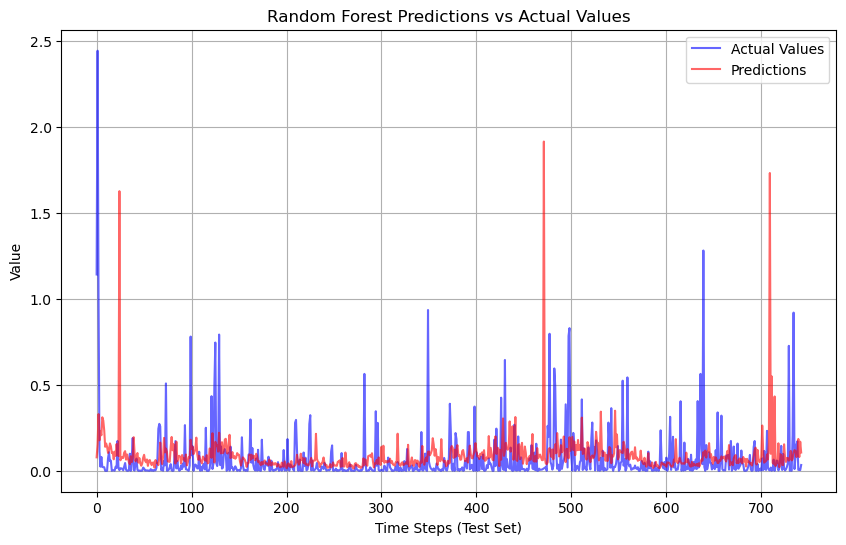

In [35]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual Values", color="blue", alpha=0.6)
plt.plot(y_predRF, label="Predictions", color="red", alpha=0.6)
plt.title("Random Forest Predictions vs Actual Values")
plt.xlabel("Time Steps (Test Set)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Combinando Modelos

[0.07918751 0.21846397 0.50738774 0.44870463 0.39068321]


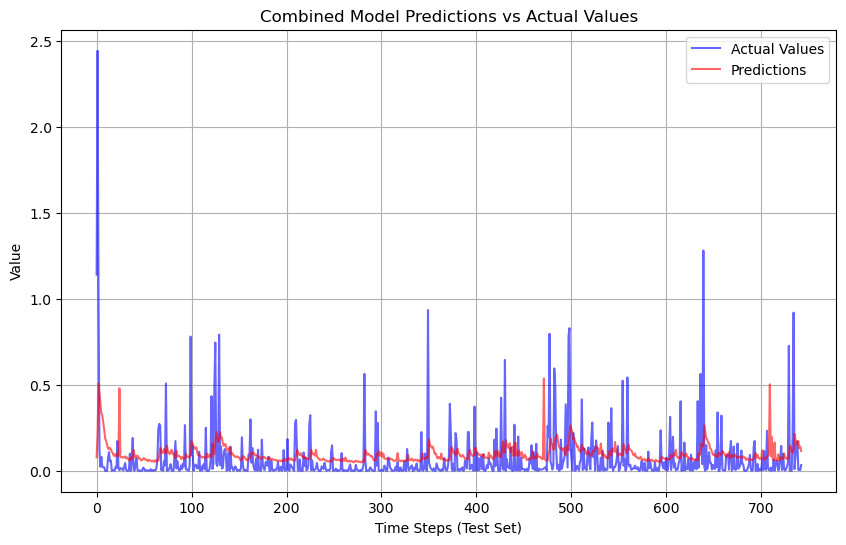

Mean Squared Error: 0.02844109984823297


In [36]:
#Gerando a série de previsões
y_predLSTM = y_predLSTM.flatten()
y_pred_lstm_2 = y_pred_lstm_2.flatten()

#y_pred = (y_predLSTM + y_predRF + forecasts)/3

# Step 1: Compute the inverse of MSEs
inverse_mse = np.array([1/mseLSTM, 1/mseRF, 1/mseG])

# Step 2: Normalize the weights
weights = inverse_mse / np.sum(inverse_mse)

forecasts = np.array(forecasts)
y_pred = weights[0]*y_predLSTM + weights[1]*y_predRF + weights[2]*forecasts

print(y_pred[:5])

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual Values", color="blue", alpha=0.6)
plt.plot(y_pred, label="Predictions", color="red", alpha=0.6)
plt.title("Combined Model Predictions vs Actual Values")
plt.xlabel("Time Steps (Test Set)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
mseC = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mseC}")

Mean Squared Error (AFTER): 0.028210499866747535


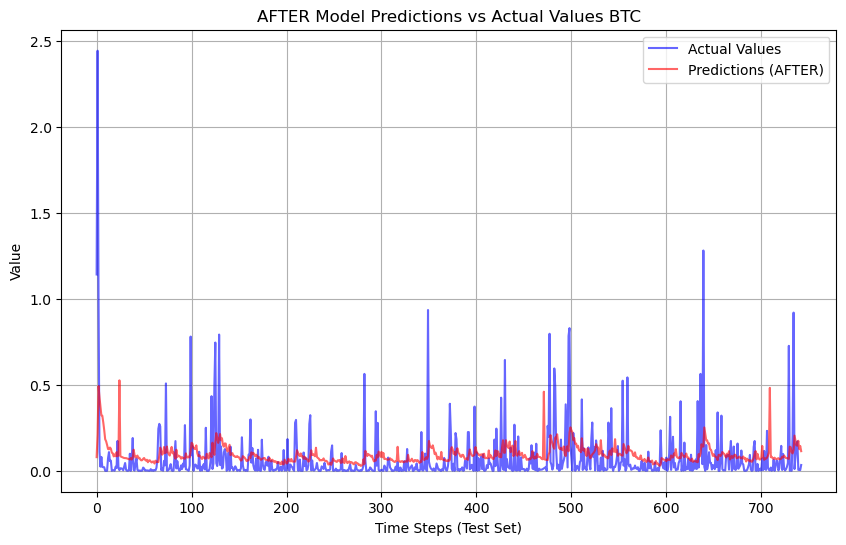

In [47]:
#AFTER

# Definir uma janela deslizante para calcular os erros recentes
window_size = 12  # Escolha um tamanho apropriado para sua série
n_predictions = len(y_test)
weights_after = []

# Inicializar previsões combinadas
y_pred_after = np.zeros(n_predictions)

# Iterar sobre as previsões usando a janela deslizante
for i in range(n_predictions):
    start_idx = max(0, i - window_size)
    end_idx = i  # Exclui o ponto atual para simular cenário realista
    
    # Subconjuntos de verdadeiros e previsões
    y_true_window = y_test.values[start_idx:end_idx]
    
    if len(y_true_window) > 0:
        # Calcular o MSE de cada modelo na janela atual
        mse_lstm = mean_squared_error(y_true_window, y_predLSTM[start_idx:end_idx])
        mse_rf = mean_squared_error(y_true_window, y_predRF[start_idx:end_idx])
        mse_g = mean_squared_error(y_true_window, forecasts[start_idx:end_idx])
        
        # Evitar divisão por zero e calcular pesos
        errors = np.array([mse_lstm, mse_rf, mse_g])
        inverse_errors = 1 / (errors + 1e-6)
        weights = inverse_errors / np.sum(inverse_errors)
        weights_after.append(weights)
    else:
        # Inicialize com pesos iguais se a janela ainda não está preenchida
        weights = np.array([1/3, 1/3, 1/3])
    
    # Previsão combinada para o ponto atual
    y_pred_after[i] = (weights[0] * y_predLSTM[i] +
                       weights[1] * y_predRF[i] +
                       weights[2] * forecasts[i])

# Converter pesos para array para análise posterior
weights_after = np.array(weights_after)

# Avaliar o modelo combinado
mse_after = mean_squared_error(y_test, y_pred_after)
print(f"Mean Squared Error (AFTER): {mse_after}")

# Plotar valores reais vs previsões (AFTER)
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual Values", color="blue", alpha=0.6)
plt.plot(y_pred_after, label="Predictions (AFTER)", color="red", alpha=0.6)
plt.title("AFTER Model Predictions vs Actual Values BTC")
plt.xlabel("Time Steps (Test Set)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [43]:
import pandas as pd

# Criar o dataframe com valores realizados e previsões
BTC_trade = pd.DataFrame({
    "Daily Return": btc_data['Daily_Return'][split_index:],
    "Predicted Vol": y_pred_after,
})

BTC_trade.to_csv('resultadosBTC.csv', index=True)


# Tabela com o fitting dos modelos


In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Função corrigida para calcular MASE
def calculate_mase(y_true, y_pred, y_train):
    if len(y_train) < 2:  # Verifica se há dados suficientes para calcular o naive_forecast
        return np.nan  # Caso não haja, retorna NaN
    naive_forecast = np.mean(np.abs(np.diff(y_train)))  # Usa np.diff para simplificar o cálculo
    if naive_forecast == 0:  # Evitar divisão por zero
        return np.inf  # Retorna infinito se não houver variação
    mase = np.mean(np.abs(y_true - y_pred)) / naive_forecast
    return mase

# Dados para os modelos
metrics = []

# Calculando métricas para o modelo GARCH
rmse_garch = np.sqrt(mean_squared_error(varReal, forecast_df['Forecast']))
mae_garch = mean_absolute_error(varReal, forecast_df['Forecast'])
mape_garch = np.mean(np.abs((varReal - forecast_df['Forecast']) / varReal)) * 100
mase_garch = calculate_mase(varReal, forecast_df['Forecast'], train_data)
metrics.append(['GARCH', rmse_garch, mae_garch, mape_garch, mase_garch])

# Calculando métricas para o modelo LSTM
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_predLSTM))
mae_lstm = mean_absolute_error(y_test, y_predLSTM)
mape_lstm = np.mean(np.abs((y_test - y_predLSTM) / y_test)) * 100
mase_lstm = calculate_mase(y_test, y_predLSTM, train_data)
metrics.append(['LSTM', rmse_lstm, mae_lstm, mape_lstm, mase_lstm])

# Calculando métricas para o modelo LSTM 2
rmse_lstm_2 = np.sqrt(mean_squared_error(y_test, y_pred_lstm_2))
mae_lstm_2 = mean_absolute_error(y_test, y_pred_lstm_2)
mape_lstm_2 = np.mean(np.abs((y_test - y_pred_lstm_2) / y_test)) * 100
mase_lstm_2 = calculate_mase(y_test, y_pred_lstm_2, train_data)
metrics.append(['LSTM 2', rmse_lstm_2, mae_lstm_2, mape_lstm_2, mase_lstm_2])

# Calculando métricas para o modelo Random Forest (ajustado para tamanhos iguais)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_predRF))
mae_rf = mean_absolute_error(y_test, y_predRF)
mape_rf = np.mean(np.abs((y_test - y_predRF) / y_test)) * 100
mase_rf = calculate_mase(y_test, y_predRF, train_data)
metrics.append(['Random Forest', rmse_rf, mae_rf, mape_rf, mase_rf])

# Calculando métricas para o modelo combinado
rmse_comb = np.sqrt(mean_squared_error(y_test, y_pred))
mae_comb = mean_absolute_error(y_test, y_pred)
mape_comb = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mase_comb = calculate_mase(y_test, y_pred, train_data)
metrics.append(['Combined Model', rmse_comb, mae_comb, mape_comb, mase_comb])

# Calculando métricas para o modelo AFTER
rmse_comb = np.sqrt(mean_squared_error(y_test, y_pred_after))
mae_comb = mean_absolute_error(y_test, y_pred_after)
mape_comb = np.mean(np.abs((y_test - y_pred_after) / y_test)) * 100
mase_comb = calculate_mase(y_test.values, y_pred_after, train_data)
metrics.append(['Combined Model (AFTER)', rmse_comb, mae_comb, mape_comb, mase_comb])

# Criando DataFrame com as métricas
metrics_df = pd.DataFrame(metrics, columns=['Model', 'RMSE', 'MAE', 'MAPE', 'MASE'])
metrics_df["Ranking_RMSE"] = metrics_df["RMSE"].rank(method="min")
metrics_df = metrics_df.sort_values(by='RMSE', ascending=True)

# Exibindo a tabela de métricas no console
print(metrics_df)

                    Model      RMSE       MAE          MAPE      MASE  \
1                    LSTM  0.166515  0.103678  1.324511e+05  0.475216   
2                  LSTM 2  0.167180  0.093721  1.088868e+05  0.429578   
0                   GARCH  0.167763  0.098218  2.701555e+06  0.450190   
5  Combined Model (AFTER)  0.167960  0.097899  1.014984e+05  0.448725   
4          Combined Model  0.168645  0.099842  1.110438e+05  0.457630   
3           Random Forest  0.202607  0.098910  7.589605e+04  0.453362   

   Ranking_RMSE  
1           1.0  
2           2.0  
0           3.0  
5           4.0  
4           5.0  
3           6.0  


In [ ]:
# Salvar o DataFrame como um arquivo CSV
#metrics_df.to_csv('metricsBTC.csv', index=False)

In [41]:
# Resíduos para os modelos
resLSTM = y_test - y_predLSTM
resRF = y_test - y_predRF
resG = y_test - forecast_df['Forecast']
resLSTM2 = y_test - y_pred_lstm_2
resCombined = y_test - y_pred

# Criando DataFrame com todos os resíduos
residuo = pd.DataFrame({
    'LSTM': resLSTM,
    'RF': resRF,
    'Garch': resG,
    'LSTM 2': resLSTM2,
    'Combined': resCombined,
    'After': y_test - y_pred_after
})

# Estatísticas descritivas dos resíduos
resumo_residuos = residuo.describe()

# Exibindo estatísticas descritivas
print("Estatísticas Descritivas dos Resíduos:")
print(resumo_residuos)


Estatísticas Descritivas dos Resíduos:
             LSTM          RF       Garch      LSTM 2    Combined       After
count  743.000000  743.000000  743.000000  743.000000  743.000000  743.000000
mean    -0.035337   -0.021095   -0.025990   -0.019177   -0.028260   -0.025337
std      0.162832    0.201642    0.166043    0.166189    0.166372    0.166150
min     -0.407843   -1.901205   -0.467380   -0.339713   -0.522793   -0.522598
25%     -0.088890   -0.074585   -0.084417   -0.080968   -0.085627   -0.083669
50%     -0.075357   -0.043978   -0.059324   -0.052426   -0.061351   -0.058915
75%     -0.038696   -0.010921   -0.028325   -0.022695   -0.032528   -0.027476
max      2.175548    2.290091    2.230745    2.330433    2.225065    2.231886


In [ ]:
# Exportando a tabela para um arquivo CSV
#resumo_residuos.to_csv('estatisticas_residuosBTC.csv', index=True)